# coco, YOLOv5データセットに合わせたnotebookを作成

Labelbox（2020）フォーマットを使用！！

PascalVOC(xml)ファイル編集用

# アノテーションファイルをダウンロード

アノテーションファイル（Downloads）をダウンロード

In [ ]:
#グーグルドライブからファイルをダウンロードする方法　　　　TODO zipファイルのトークン変更！！！！
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
# file_id = '17j-pzxgiQNepFzE3_MsqRR2RsNQVhNKa' # Downloads_sumi.zip
file_id = '1uvSlR5QEVPEX3UY5GG-ngQ9QL24IlTAu' # Downloads_sumi918.zip


#欲しいフォルダ名
destination = 'Downloads.zip'

download_file_from_google_drive(file_id, destination)

!unzip Downloads
print("Downloadsファイルの解凍が完了しました。")

Archive:  Downloads.zip
  inflating: Downloads/export-2020-09-21T02_40_17.775Z.json  
Downloadsファイルの解凍が完了しました。


# PascalVOC形式データセット作成

In [ ]:
import json 
import os
import numpy as np
import cv2
# from pascal_voc_writer import Writer

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"


if "coco" not in os.listdir(base_path):
    os.makedirs(os.path.join(base_path, "coco"))
else:
    print("cocoは既に存在します")
SAVE_DIR = os.path.join(base_path, "coco") # cocoのrootディレクトリ作成

①imagesディレクトリを作成し、jsonファイルからimgをダウンロード

②labelsディレクトリを作成し、各画像のxmlファイルを作成。

In [ ]:
import json 
import os
import numpy as np
import cv2
import requests

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"

FILE_PATH = os.path.join(base_path, "Downloads") # jsonファイルのpath 

file_index = os.listdir(FILE_PATH) #アノテーションファイルをリストで取得
print('jsonファイルの数：', len(file_index))

# imagesディレクトリを作成
if "images" not in os.listdir(os.path.join(base_path, "coco")):
    os.makedirs(os.path.join(base_path, "coco", "images"))
else:
    print("imagesは既に存在します")
SAVE_IMG_DIR = os.path.join(base_path, "coco", "images") # 保存するimgファイルのpath

# labelsディレクトリを作成
if "labels" not in os.listdir(os.path.join(base_path, "coco")):
    os.makedirs(os.path.join(base_path, "coco", "labels"))
else:
    print("labelsは既に存在します")
SAVE_ANNO_DIR = os.path.join(base_path, "coco", "labels") # 保存するファイルのpath

# annotationsディレクトリを作成
if "annotations" not in os.listdir(os.path.join(base_path, "coco")):
    os.makedirs(os.path.join(base_path, "coco", "annotations"))
else:
    print("annotationsは既に存在します")


classes = ['hinageshi', 'noharagarashi', 'fieldPancy', 'nezumimugi']

count_skip = 0  # continueをカウントする


# jsonファイル（クラスごとに分かれている）を順番に読み取り
for json_name in file_index:
    with open(os.path.join(FILE_PATH, json_name)) as json_f:
        json_open = json_f 
        json_load = json.load(json_open)
        # 各クラスの画像ファイルを読み取り(jsonを一行ごと読み取る、つまり画像を一枚ずつ読み取る)
        for json_row in json_load: # jsonファイル　１行
            # bboxがない画像はスキップする
            if not json_row['Label']:
                count_skip = count_skip + 1
                print('continue', count_skip, json_row['Label'])
                continue

            objects = json_row['Label']['objects']
            file_name = json_row['External ID']
            url = json_row['Labeled Data']
            response = requests.get(url)
            image = response.content
            # ①imgファイルを保存
            with open(os.path.join(SAVE_IMG_DIR, file_name), "wb") as f:                 # TODO どうやってイメージを振り分けるか？？？
                f.write(image)
            print(file_name, os.path.join(SAVE_ANNO_DIR, file_name))
            # imgを読み込み
            src = cv2.imread(os.path.join(SAVE_IMG_DIR, file_name))
            h, w, c = src.shape

            boxes = []

            for num, obj in enumerate(objects):
                box = obj['bbox']
                top, left = (box['top'], box['left'])
                height, width = (box['height'], box['width'])
                name = obj['title']

                x_center = int(left) + int(width) / 2  # create x_center
                y_center = int(top) + int(height) / 2  # create y_center
                width = int(width)
                height = int(height)

                x_center, width = (x_center/w, width/w)  # divide x_center and width by image width
                y_center, height = (y_center/h, height/h)   # divide y_center and height by image height
                
                clsnum = classes.index(name)              

                # box line 追加('class x_center y_center width height')
                boxes.append(str(clsnum)+' '+str(x_center)+' '+str(y_center)+' '+str(width)+' '+str(height))

            # ②labelsファイルを保存
            save_str = '\n'.join(boxes)            
            with open(os.path.join(SAVE_ANNO_DIR, file_name.replace('png', 'txt')), "w") as f:                
                f.write(save_str)
                  
print('continue:', count_skip)


jsonファイルの数： 1
200424_7_4_06.png /content/coco/labels/200424_7_4_06.png
200424_7_2_08.png /content/coco/labels/200424_7_2_08.png
200424_7_4_03.png /content/coco/labels/200424_7_4_03.png
200424_7_2_05.png /content/coco/labels/200424_7_2_05.png
200424_7_2_29.png /content/coco/labels/200424_7_2_29.png
200424_7_2_02.png /content/coco/labels/200424_7_2_02.png
200424_7_2_26.png /content/coco/labels/200424_7_2_26.png
200424_7_4_28.png /content/coco/labels/200424_7_4_28.png
200424_7_2_22.png /content/coco/labels/200424_7_2_22.png
200424_7_4_24.png /content/coco/labels/200424_7_4_24.png
200424_7_2_19.png /content/coco/labels/200424_7_2_19.png
200424_7_4_21.png /content/coco/labels/200424_7_4_21.png
200424_7_2_16.png /content/coco/labels/200424_7_2_16.png
200424_7_4_18.png /content/coco/labels/200424_7_4_18.png
200424_7_2_12.png /content/coco/labels/200424_7_2_12.png
200424_7_4_15.png /content/coco/labels/200424_7_4_15.png
200424_7_4_11.png /content/coco/labels/200424_7_4_11.png
200424_7_4_08.png

In [ ]:
# xmlファイルの数を確認
import json 
import os
import imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt

file_list = os.listdir("/content/coco/images")
# file_list = os.listdir(os.path.join("/content/weeds", "hamasuge"))
print(len(file_list))

894


In [ ]:
# jpgファイルの数を確認
import json 
import os
import imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt

file_list = os.listdir("/content/coco/labels")
print(len(file_list))

894


③train, valフォルダにデータを振り分け！！

In [ ]:
import json 
import os
import numpy as np
import cv2

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"

# images dir 
# train2017ディレクトリを作成
if "train2017" not in os.listdir(os.path.join(base_path, "coco", "images")):
    os.makedirs(os.path.join(base_path, "coco", "images", "train2017"))
else:
    print("train2017は既に存在します")

# val2017ディレクトリを作成
if "val2017" not in os.listdir(os.path.join(base_path, "coco", "images")):
    os.makedirs(os.path.join(base_path, "coco", "images", "val2017"))
else:
    print("val2017は既に存在します")

# test2017ディレクトリを作成
if "test2017" not in os.listdir(os.path.join(base_path, "coco", "images")):
    os.makedirs(os.path.join(base_path, "coco", "images", "test2017"))
else:
    print("test2017は既に存在します")

# labels dir 
# train2017ディレクトリを作成
if "train2017" not in os.listdir(os.path.join(base_path, "coco", "labels")):
    os.makedirs(os.path.join(base_path, "coco", "labels", "train2017"))
else:
    print("train2017は既に存在します")

# val2017ディレクトリを作成
if "val2017" not in os.listdir(os.path.join(base_path, "coco", "labels")):
    os.makedirs(os.path.join(base_path, "coco", "labels", "val2017"))
else:
    print("val2017は既に存在します")

# test2017ディレクトリを作成
if "test2017" not in os.listdir(os.path.join(base_path, "coco", "labels")):
    os.makedirs(os.path.join(base_path, "coco", "labels", "test2017"))
else:
    print("test2017は既に存在します")


In [ ]:
import os, shutil
from os.path import join
import random

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"
imagelist = os.listdir(os.path.join(base_path, 'coco', 'images'))  # images

hinageshi = []
noharagarashi = []
fieldPancy = []
nezumimugi = []

for image in imagelist:
    if image == '.ipynb_checkpoints':
        continue
    elif image == 'train2017':
        continue
    elif image == 'val2017':
        continue
    elif image == 'test2017':
        continue
    cls_index = image.split('_')[2]
    if cls_index =='1':
        hinageshi.append(image)
    elif cls_index =='2':
        noharagarashi.append(image)
    elif cls_index =='3':
        fieldPancy.append(image)
    elif cls_index =='4':
        nezumimugi.append(image)
print('hina len:', len(hinageshi), hinageshi)
print('nohara len:', len(noharagarashi), noharagarashi)
print('field len:', len(fieldPancy), fieldPancy)
print('nezumi len:', len(nezumimugi), nezumimugi)

batch_size = 16

# valデータを作成
for dir_type in ["val2017", "test2017"]:
    hina28 = random.sample(hinageshi, int(batch_size))
    for hina in hina28:
        name = hina.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        hinageshi.remove(hina)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('hina len:', len(hinageshi))

    nohara12 = random.sample(noharagarashi, int(batch_size))
    for nohara in nohara12:
        name = nohara.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        noharagarashi.remove(nohara)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('nohara len:', len(noharagarashi))

    field28 = random.sample(fieldPancy, int(batch_size))
    for field in field28:
        name = field.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        fieldPancy.remove(field)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('field len:', len(fieldPancy))

    nezumi12 = random.sample(nezumimugi, int(batch_size))
    for nezumi in nezumi12:
        name = nezumi.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        nezumimugi.remove(nezumi)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('nezumi len:', len(nezumimugi))

# trainデータを作成
for dir_type in ["train2017"]:
    num = len(hinageshi) // batch_size
    hina_ = random.sample(hinageshi, int(num*batch_size))
    for hina in hina_:
        name = hina.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        hinageshi.remove(hina)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('hina len:', len(hinageshi))

    num = len(noharagarashi) // batch_size
    nohara_ = random.sample(noharagarashi, int(num*batch_size))
    for nohara in nohara_:
        name = nohara.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        noharagarashi.remove(nohara)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('nohara len:', len(noharagarashi))

    num = len(fieldPancy) // batch_size
    field_ = random.sample(fieldPancy, int(num*batch_size))
    for field in field_:
        name = field.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        fieldPancy.remove(field)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('field len:', len(fieldPancy))

    num = len(nezumimugi) // batch_size
    nezumi_ = random.sample(nezumimugi, int(num*batch_size))
    for nezumi in nezumi_:
        name = nezumi.split('.')
        fp_fig = name[0] + '.png'
        fp_txt = name[0] + '.txt'
        nezumimugi.remove(nezumi)
        # 移動元のファイル(imge)
        path1 = os.path.join(base_path, 'coco', 'images', fp_fig)
        # 移動先のファイル(imge)
        path2= os.path.join(base_path, 'coco', 'images', dir_type, fp_fig)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))

        # 移動元のファイル(label)
        path1 = os.path.join(base_path, 'coco', 'labels', fp_txt)
        # 移動先のファイル(label)
        path2= os.path.join(base_path, 'coco', 'labels', dir_type, fp_txt)
        # ファイルを移動
        new_path = shutil.move(path1, path2)
        # ファイルの存在確認
        print(os.path.exists(path2))
    print('nezumi len:', len(nezumimugi))

print("振り分け完了！")




hina len: 315 ['200514_7_1_11.png', '200512_7_1_28.png', '200511_7_1_18.png', '200424_7_1_21.png', '200423_7_1_21.png', '200512_7_1_18.png', '200504_7_1_28.png', '200423_7_1_17.png', '200511_7_1_29.png', '200507_7_1_16.png', '200512_7_1_24.png', '200502_7_1_22.png', '200427_7_1_23.png', '200502_7_1_24.png', '200508_7_1_14.png', '200423_7_1_22.png', '200430_7_1_15.png', '200511_7_1_26.png', '200423_7_1_12.png', '200511_7_1_09.png', '200512_7_1_27.png', '200423_7_1_18.png', '200502_7_1_12.png', '200428_7_1_20.png', '200502_7_1_20.png', '200512_7_1_16.png', '200428_7_1_04.png', '200502_7_1_18.png', '200427_7_1_29.png', '200507_7_1_14.png', '200430_7_1_23.png', '200514_7_1_30.png', '200511_7_1_14.png', '200507_7_1_06.png', '200502_7_1_28.png', '200514_7_1_02.png', '200504_7_1_08.png', '200504_7_1_17.png', '200430_7_1_18.png', '200508_7_1_19.png', '200508_7_1_28.png', '200423_7_1_15.png', '200512_7_1_03.png', '200430_7_1_07.png', '200504_7_1_16.png', '200430_7_1_06.png', '200502_7_1_04.png'

In [ ]:
import os
filelist = os.listdir('/content/coco/labels/train2017')
len(filelist)

736

In [ ]:
import os
import random

def make_train_files(base_path):
    
    train_file = open(os.path.join(base_path, "coco", "train2017.txt"),'w')
    val_file = open(os.path.join(base_path, "coco", "val2017.txt"),'w')
    test_file = open(os.path.join(base_path, "coco", "test-dev2017.txt"),'w')
    num = 0
    # 
    for dir in ["train2017", "val2017", "test2017"]:
        text = ""
        for file in os.listdir(os.path.join(base_path, "coco", "images", dir)):
            file_path = "./images/" + os.path.join(dir, file)
            text =text + file_path + '\n' 
        if dir=="train2017":
            train_file.write(text)
        elif dir=="val2017":
            val_file.write(text)
        elif dir=="test2017":
            test_file.write(text)

In [ ]:
# base_path = r'C:\Users\spc134\Desktop\PascalVOC'
base_path = "/content"

make_train_files(base_path)


json作成

In [ ]:
import json
import io
import logging
import datetime as dt
import os
import numpy as np
from skimage import measure
from PIL import Image
from pycocotools import mask
from tqdm import tqdm

input_json = '/content/Downloads/export-2020-09-21T02_40_17.775Z.json'

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"


def main(dir):
    count_skip = 0  # continueをカウントする
    path = dir + '2017'
    # print('path', path)

    with open(input_json) as f:
        jsn = json.load(f)
        print('jsn :', type(jsn))

    coco = make_coco_metadata(jsn[0]['Project Name'], jsn[0]['Created By'])
    
    # ディレクトリに存在するimageのリストを作成
    img_list = os.listdir(os.path.join(base_path, 'coco', 'images', path))
    # print(img_list)

    for data in tqdm(jsn):
        # if not data['Label']:
        #     count_skip = count_skip + 1
        #     print('continue', count_skip, data['Label'])
        #     continue

        # リスト内のimageのみアノテーションデータを作成
        if data['External ID'] in img_list:
            convert_data(coco, data['ID'], data['External ID'],
                         data['Labeled Data'], data['Label']['objects'], path)

    with open(os.path.join(base_path, 'coco', 'annotations', 'instances_{}.json'.format(path)), 'w') as f:
        json.dump(coco, f, indent=4)

def convert_data(coco, id, file_name, image_url, labels, path):
    image = {
        "id": id,
        "file_name": file_name,
        "license": None,
        "flickr_url": image_url,
        "coco_url": image_url,
        "date_captured": None,
    }

    file_path = os.path.join(base_path, 'coco', 'images', path, file_name)
    image['width'], image['height'] = Image.open(file_path).size
    coco['images'].append(image)

    # labelがない場合、処理をスキップ
    if labels == []:
        return

    category_id = None

    for label_data in labels:
        for c in coco['categories']:
            if c['name'] == label_data['title']:
                category_id = c['id']

        if category_id == None:
            category_id = len(coco['categories']) + 1
            category = {
                # supercategoryがある場合はここを修正する
                'supercategory': label_data['title'],
                'id': category_id,
                'name': label_data['title']
            }
            coco['categories'].append(category)

        #conert("L")でアルファチャンネルを消して、２D画像化
        binary_mask=np.array(Image.open(file_path).convert("L"))

        create_annotation_info(coco=coco, image_id=id, category_id=category_id, binary_mask=binary_mask)

def create_annotation_info(coco, image_id, category_id, binary_mask, tolerance=2):
    binary_mask_encoded = mask.encode(
        np.asfortranarray(binary_mask.astype(np.uint8)))

    area = mask.area(binary_mask_encoded)
    bounding_box = mask.toBbox(binary_mask_encoded)
    polygons = get_polygons(binary_mask)

    #labelboxが出力するcocoはiscrowd:0で固定されていたのでこうしている
    annotation = {
        "id": len(coco['annotations']) + 1,
        "image_id": image_id,
        "category_id": category_id,
        "iscrowd": 0,
        "area": area.tolist(),
        "bbox": bounding_box.tolist(),
        "segmentation": polygons
    }

    coco['annotations'].append(annotation)

def get_polygons(binary_mask):
    polygons = []
    # pad mask to close contours of shapes which start and end at an edge
    padded_binary_mask = np.pad(
        binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, tolerance=5)
        if len(contour) < 3:
            continue
        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        # after padding and subtracting 1 we may get -0.5 points in our segmentation
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)

    return polygons

def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

def make_coco_metadata(project_name, created_by):
    return {
        'info': {
            'year': dt.datetime.now(dt.timezone.utc).year,
            'version': None,
            'description': project_name,
            'contributor': created_by,
            'url': 'labelbox.com',
            'date_created': dt.datetime.now(dt.timezone.utc).isoformat()
        },
        'images': [],
        'annotations': [],
        'licenses': [],
        'categories': []
    }


In [ ]:
main('train')
main('val')
main('test')

  0%|          | 2/918 [00:00<00:58, 15.64it/s]

jsn : <class 'list'>


  1%|          | 6/918 [00:00<00:21, 42.28it/s]

jsn : <class 'list'>


  0%|          | 1/918 [00:00<02:34,  5.93it/s]

jsn : <class 'list'>


100%|██████████| 918/918 [00:12<00:00, 74.16it/s]


確認！！！画像にボックスのプロットを表示

200514_7_3_27.txt
/content/coco/images/train2017/200514_7_3_27.png
2 0.2689243027888446 0.29430379746835444 0.0796812749003984 0.06645569620253164
115 165 155 207
2 0.3754980079681275 0.43591772151898733 0.08565737051792828 0.061708860759493674
167 256 210 295
2 0.38147410358565736 0.5253164556962026 0.08964143426294821 0.06645569620253164
169 311 214 353
2 0.43725099601593626 0.557753164556962 0.061752988047808766 0.0680379746835443
204 331 235 374
2 0.5199203187250996 0.6068037974683544 0.07569721115537849 0.07120253164556962
242 361 280 406
2 0.41932270916334663 0.6542721518987342 0.08964143426294821 0.07436708860759493
188 390 233 437
2 0.5358565737051793 0.6962025316455697 0.055776892430278883 0.06645569620253164
255 419 283 461
[115, 165]
[[[115, 165], [155, 207]], [[167, 256], [210, 295]], [[169, 311], [214, 353]], [[204, 331], [235, 374]], [[242, 361], [280, 406]], [[188, 390], [233, 437]], [[255, 419], [283, 461]]]
<class 'numpy.ndarray'>
200430_7_3_09.txt
/content/coco/images

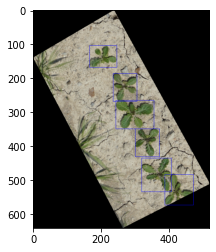

In [ ]:
from bs4 import BeautifulSoup
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# base_path = r'C:\Users\spc134\Desktop\makecoco'
base_path = "/content"

filedir = os.path.join(base_path, "coco", "labels")
filedir_fig = os.path.join(base_path, "coco", "images")


for dir in ["train2017", "val2017", "test2017"]:
    filelist = os.listdir(os.path.join(filedir, dir)) # ファイル名をリストで取得
    for i, filename in enumerate(filelist):
        print(filename)
        name = filename.split('.')
        # '.ipynb_checkpoints'の場合スキップ
        if filename == '.ipynb_checkpoints':
            continue
        fp_xml = os.path.join(filedir, dir, name[0] +'.txt')
        fp_fig = os.path.join(filedir_fig, dir, name[0] + '.png')
        print(fp_fig)
        # ファイルの読み込み
        with open(fp_xml) as f:
            f_r = f.read()
        boxlist =str(f_r).split('\n')
        src = cv2.imread(fp_fig)
        src_mark = src.copy()
        h, w, c = src.shape

        src_pts = []
        for box in boxlist:
            print(box)
            cls, x_c, y_c, w_, h_ = box.split(' ')
            x_c = float(x_c)*w
            w_ = float(w_)*w
            y_c = float(y_c)*h
            h_ = float(h_)*h

            xmin = int(x_c - w_/2)
            ymin = int(y_c - h_/2)
            xmax = int(x_c + w_/2)
            ymax = int(y_c + h_/2)
            print(xmin,ymin,xmax,ymax)
            src_pts.append([[xmin, ymin], [xmax, ymax]])
            # break
        print(src_pts[0][0])
        print(src_pts)
        for pt in src_pts:
            cv2.rectangle(src_mark, tuple(pt[0]), tuple(pt[1]), (255, 0, 0), thickness=1)
        print(type(src))
        # cv2.imwrite(savedir, src)
        plt.imshow(cv2.cvtColor(src_mark, cv2.COLOR_BGR2RGB))
        if i==30:
            print('number==', i)
            break




In [ ]:
%cd /content

/content


cocoを圧縮

In [ ]:
!zip -r coco coco

  adding: coco/ (stored 0%)
  adding: coco/labels/ (stored 0%)
  adding: coco/labels/200502_7_1_09.txt (deflated 58%)
  adding: coco/labels/200427_7_3_28.txt (deflated 70%)
  adding: coco/labels/test2017/ (stored 0%)
  adding: coco/labels/test2017/200423_7_2_20.txt (deflated 59%)
  adding: coco/labels/test2017/200423_7_4_15.txt (deflated 54%)
  adding: coco/labels/test2017/200424_7_4_06.txt (deflated 54%)
  adding: coco/labels/test2017/200430_7_4_07.txt (deflated 49%)
  adding: coco/labels/test2017/200430_7_2_22.txt (deflated 58%)
  adding: coco/labels/test2017/200507_7_3_06.txt (deflated 62%)
  adding: coco/labels/test2017/200428_7_4_23.txt (deflated 52%)
  adding: coco/labels/test2017/200428_7_4_10.txt (deflated 53%)
  adding: coco/labels/test2017/200508_7_1_11.txt (deflated 55%)
  adding: coco/labels/test2017/200512_7_1_06.txt (deflated 55%)
  adding: coco/labels/test2017/200507_7_3_24.txt (deflated 61%)
  adding: coco/labels/test2017/200428_7_2_24.txt (deflated 59%)
  adding: coco/